In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy as sc
import utils as ut
import glob
from sklearn.metrics import classification_report
from scipy.stats import pearsonr
from utils import de_score
import random
import seaborn as sns
import matplotlib.pyplot as plt
from scanpypip.utils import get_de_dataframe

import warnings
warnings.filterwarnings('ignore')
from scipy.stats import ranksums,ttest_ind


c:\Users\Varun\anaconda3\envs\scDEAL\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<div class="alert alert-info">

**Note**
    
This notebook provides analysis on the umap, the performance score, and the predictive gene module score correlation. Require input is the h5ad file of the transfer learning
    
</div>  

# Set parameters of scanpy

In [2]:
sc.settings.verbosity = 0  # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.logging.print_versions()
sc.settings.set_figure_params(dpi=300, frameon=False, figsize=(3, 3), facecolor='white')  # low dpi (dots per inch) yields small inline figures

Input h5ad of trained datasets

In [3]:
# List all files in the directoty
h5ad_list = glob.glob("save/adata/*.h5ad")

In [4]:
h5ad_list

['save/adata\\GSE110894integrate_data_GSE110894_drug_I.BET.762_bottle_512_edim_256,128_pdim_128,64_model_VAE_dropout_0.1_gene_F_lr_0.5_mod_new_sam_upsampling.h5ad',
 'save/adata\\GSE112274integrate_data_GSE112274_drug_GEFITINIB_bottle_256_edim_512,256_pdim_256,128_model_VAE_dropout_0.1_gene_F_lr_0.5_mod_new_sam_no.h5ad',
 'save/adata\\GSE117872_HN120integrate_data_GSE117872_HN120_drug_CISPLATIN_bottle_512_edim_256,128_pdim_128,64_model_VAE_dropout_0.3_gene_F_lr_0.01_mod_new_sam_SMOTE.h5ad',
 'save/adata\\GSE117872_HN137integrate_data_GSE117872_HN137_drug_CISPLATIN_bottle_256_edim_512,256_pdim_256,128_model_VAE_dropout_0.3_gene_F_lr_0.01_mod_new_sam_upsampling.h5ad',
 'save/adata\\GSE140440integrate_data_GSE140440_drug_DOCETAXEL_bottle_512_edim_256,128_pdim_256,128_model_VAE_dropout_0.1_gene_F_lr_0.01_mod_new_sam_upsampling.h5ad',
 'save/adata\\GSE149383integrate_data_GSE149383_drug_ERLOTINIB_bottle_512_edim_512,256_pdim_256,128_model_VAE_dropout_0.3_gene_F_lr_0.01_mod_new_sam_upsamplin

Define cell type column name in the meta data file of each dataset

In [5]:
CELL_TYPE_KEY = {"GSE117872_HN137":"cell_color","GSE117872_HN120":"cell_color","GSE110894":"Sample name","GSE140440":"sensitivity","GSE112274":"sensitivity",
                "GSE149383":"sensitivity"}

Select data set of interested

In [6]:
h5ad_list = [h5ad_list[0]]

In [7]:
h5ad_list

['save/adata\\GSE110894integrate_data_GSE110894_drug_I.BET.762_bottle_512_edim_256,128_pdim_128,64_model_VAE_dropout_0.1_gene_F_lr_0.5_mod_new_sam_upsampling.h5ad']

In [8]:
#Change according to required data
intested = "GSE110894"

# Generated 3 figures comparing before, after tarnsfer, ground truth

And it will save the F1 score before and after the transfer learning

In [9]:
# Random score test
def ran_test_score(adata,n_iters=1000):
    ran_results1 = []
    ran_results2 = []

    s_score,s_pval = pearsonr(adata.obs["1_score"],adata.obs["Sensitive_score"])
    r_score,r_pval = pearsonr(adata.obs["0_score"],adata.obs["Resistant_score"])


    for i in range(0,n_iters):

        gl1 = random.sample(list(adata.var.index),50)
        adata=sc.tl.score_genes(adata, gene_list=gl1,score_name="l1_score",copy=True)

        rand_score1,rand_pval1 = pearsonr(adata.obs["l1_score"],adata.obs["Sensitive_score"])
        rand_score2,rand_pval2 = pearsonr(adata.obs["l1_score"],adata.obs["Resistant_score"])

        ran_results1.append(rand_score1)
        ran_results2.append(rand_score2)
        
        
    return adata,ran_results1, s_score,s_pval ,ran_results2,r_score,r_pval

In [10]:
# Functioin to show p value on the figure
def p_string(l,score):
    score = sum(l>=score)/len(l)
    if(score==0):
        return "p < 0.001"
    else:
        return "p =" + " "+str(score)

# Show the prediction probability before transfer and after on UMAP

Index(['Plate#', 'Well position', 'Sample name', 'Index-Sort condition',
       'Well index', 'sensitive', 'sensitivity', 'Sensitive_score',
       'Resistant_score', 'n_genes', 'n_genes_by_counts', 'total_counts',
       'total_counts_mt-', 'pct_counts_mt-', 'total_counts_rps',
       'pct_counts_rps', 'total_counts_rpl', 'pct_counts_rpl', 'leiden',
       'leiden_origin', 'sens_preds_pret', 'sens_label_pret', 'sens_preds',
       'sens_label', 'rest_preds'],
      dtype='object')



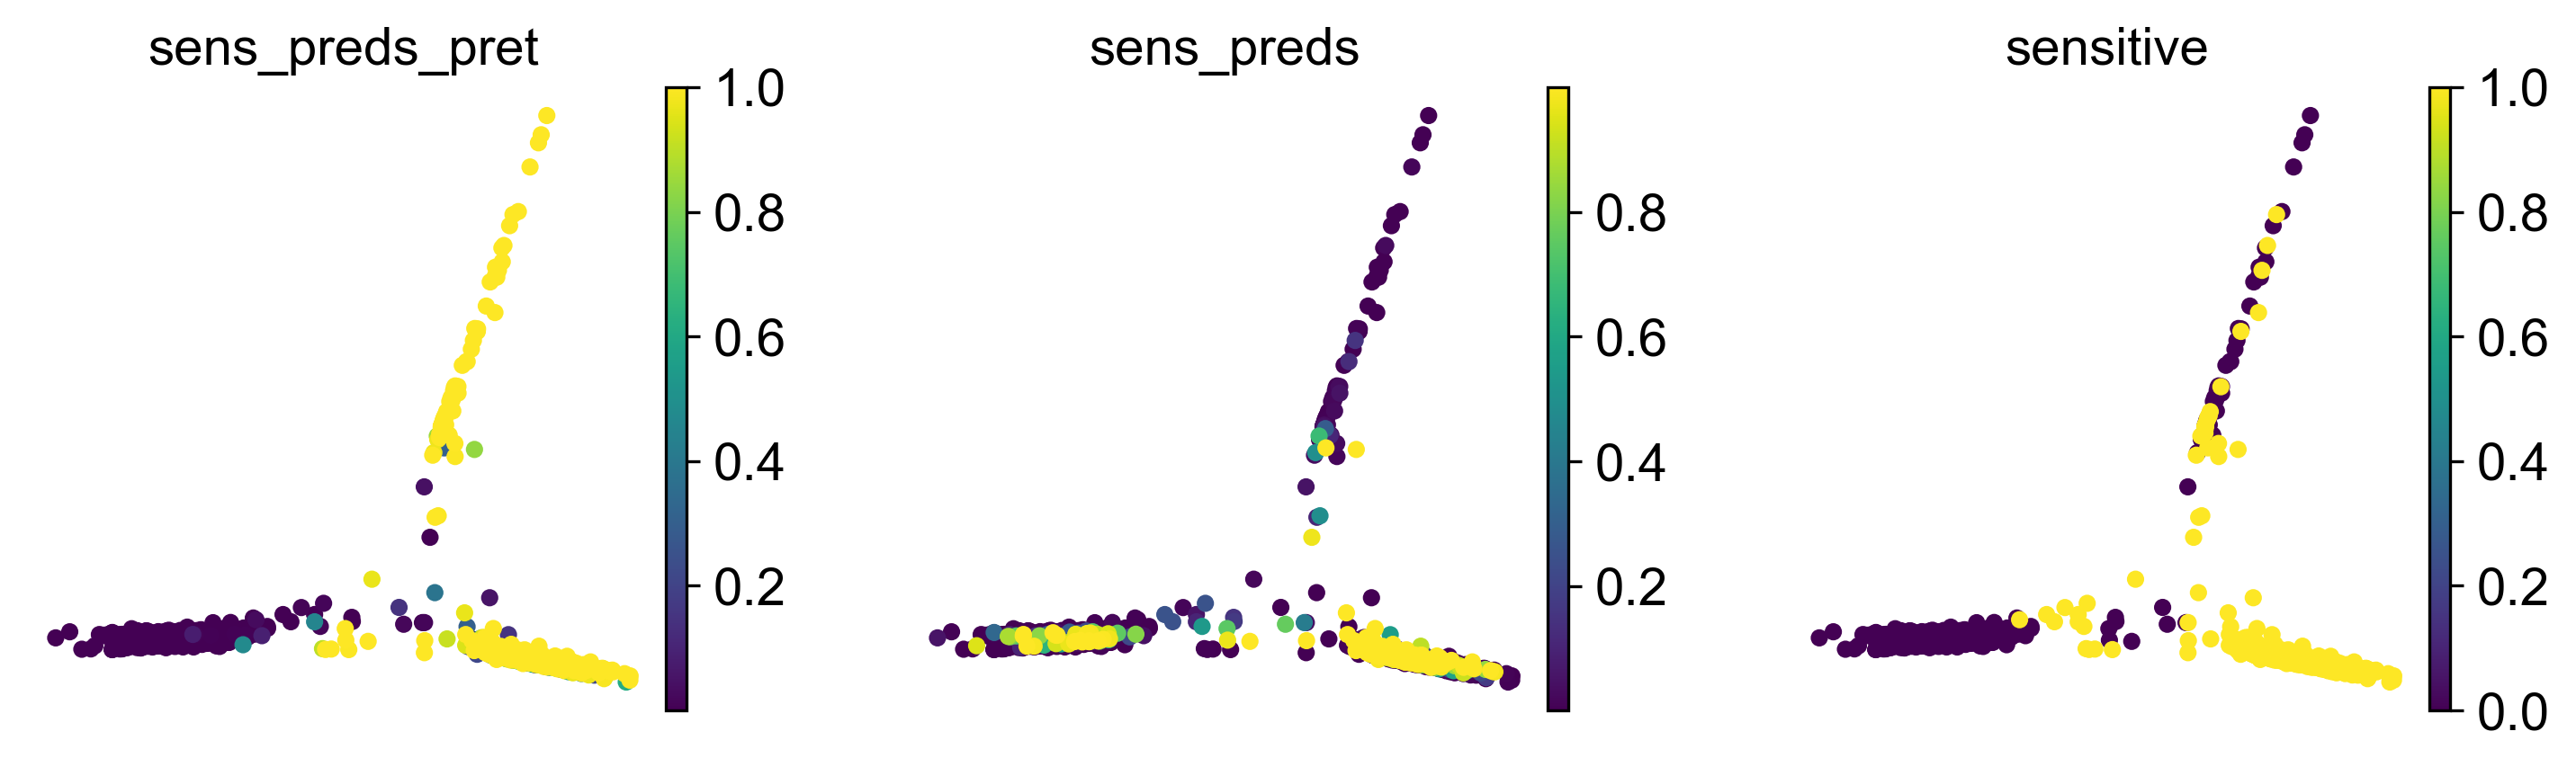

In [11]:
from sklearn.metrics import (auc, average_precision_score,
                             classification_report, mean_squared_error,
                             precision_recall_curve, r2_score, roc_auc_score)

names = []
score = []
model = []

interes_adata = None

for f in h5ad_list:
    
    
    adata = sc.read_h5ad(filename=f)
    adata.uns['log1p']["base"] = None
    
    if(f.find("117872")>0):
        adata = adata[adata.obs['cluster']!="Holiday"]

    pretrain_label = adata.obs['sens_label_pret']
    sens_label = adata.obs['sens_label']
    
        
    print(adata.obs.columns)

    grouth_truth = adata.obs['sensitive']
    sens_pb_pret = adata.obs['sens_preds_pret']
    sens_label_pret = adata.obs['sens_label_pret']
    sens_pb = adata.obs['sens_preds']

    name = f.split("1214")[0].split("\\")[1]
    # name = "GSE112274"
    
    if(name=="GSE112274"):
        adata=adata[(adata.obs["sensitivity"] != "EMPTY") & \
                    (adata.obs["sensitivity"] != "EMPTY ") ,: ]
    
    
    
    report_dict_pret = classification_report(grouth_truth, pretrain_label, output_dict=True)
    classification_report_pret_df = pd.DataFrame(report_dict_pret).T
    f1score_pret = report_dict_pret['weighted avg']['f1-score']
    ap_pret = average_precision_score(grouth_truth, sens_pb_pret)
    auroc_pret = roc_auc_score(grouth_truth, sens_label_pret)

    
    report_dict = classification_report(grouth_truth, sens_label, output_dict=True)
    classification_report_df = pd.DataFrame(report_dict).T
    f1score = report_dict['weighted avg']['f1-score']
    ap = average_precision_score(grouth_truth, sens_pb)
    auroc = roc_auc_score(grouth_truth, sens_label)
    
    names.append(name)
    score.append(f1score_pret)
    model.append("before")
    
    names.append(name)
    score.append(f1score)
    model.append("transfer")

    result = pd.DataFrame({"f1":[f1score_pret,f1score],
                          "ap":[ap_pret,ap],
                          "auroc":[auroc_pret,auroc]},index=["pretrain","transfer"])
    
    print()
    # Save the figure
    sc.pl.umap(adata,color=['sens_preds_pret','sens_preds','sensitive'],save="report_compare"+name + '.tiff')
    # Save the f1 score before and after
    result.to_csv("save/results"+name + '.csv')
    
    # Cal pred senstivie score
    adata = ut.de_score(adata,clustername='sens_label')
    
    if(f.find(intested)>0):
        interes_adata = adata

In [12]:
adata.obs

,Plate#,Well position,Sample name,Index-Sort condition,Well index,sensitive,sensitivity,Sensitive_score,Resistant_score,n_genes,...,pct_counts_rpl,leiden,leiden_origin,sens_preds_pret,sens_label_pret,sens_preds,sens_label,rest_preds,0_score,1_score
RPI1_A3,RPI1,A3,MA9 IBET RESISTANT CELLS,GR+,GGTCTATG,0,Resistant,-2.726364,14.205806,7132,...,0.0,3,3,3.752059e-05,0,0.005124,0,0.994896,0.903473,0.451179
RPI1_A4,RPI1,A4,MA9 IBET RESISTANT CELLS,GR+,GTCCGAAT,0,Resistant,-2.200808,10.421613,6815,...,0.0,3,3,1.857953e-06,0,0.001416,0,0.998601,0.926095,0.631304
RPI1_A5,RPI1,A5,MA9 IBET RESISTANT CELLS,GR+,TAGTGCGT,0,Resistant,-1.273636,5.788548,4951,...,0.0,3,3,5.344734e-07,0,0.976698,1,0.024862,0.949045,0.530729
RPI1_A6,RPI1,A6,MA9 IBET RESISTANT CELLS,GR+,GACTGTAC,0,Resistant,-3.492323,16.025484,7615,...,0.0,3,3,2.977143e-06,0,0.001900,0,0.998121,1.085778,0.322235
RPI1_A7,RPI1,A7,MA9 IBET RESISTANT CELLS,GR+,TCCAGTAG,0,Resistant,-2.236667,13.070161,6688,...,0.0,3,3,3.856121e-07,0,0.003434,0,0.996581,1.220730,0.374562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RPI7_P18,RPI7,P18,MA9 IBET RESISTANT CELLS- WITHDRAWAL,GR-,ACGTGTGT,0,Resistant,-1.348788,8.079032,5421,...,0.0,1,1,2.485875e-04,0,0.002041,0,0.997981,1.485587,0.228617
RPI7_P19,RPI7,P19,MA9 IBET RESISTANT CELLS- WITHDRAWAL,GR-,TCAGCGTA,0,Resistant,-1.234040,8.462097,5293,...,0.0,1,1,1.226340e-05,0,0.001553,0,0.998464,1.485376,0.361653
RPI7_P20,RPI7,P20,MA9 IBET RESISTANT CELLS- WITHDRAWAL,GR-,AGAAGAGG,0,Resistant,-0.823939,5.184032,4101,...,0.0,1,1,1.608930e-05,0,0.008239,0,0.991657,1.298935,0.464418
RPI7_P21,RPI7,P21,EMPTY,EMPTY,TATCCGGA,1,Sensitive,-0.295859,1.591129,2012,...,0.0,1,1,8.890074e-03,0,0.013748,0,0.985893,1.763510,0.302188


In [13]:
interes_adata

AnnData object with n_obs × n_vars = 1419 × 6644
    obs: 'Plate#', 'Well position', 'Sample name', 'Index-Sort condition', 'Well index', 'sensitive', 'sensitivity', 'Sensitive_score', 'Resistant_score', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt-', 'pct_counts_mt-', 'total_counts_rps', 'pct_counts_rps', 'total_counts_rpl', 'pct_counts_rpl', 'leiden', 'leiden_origin', 'sens_preds_pret', 'sens_label_pret', 'sens_preds', 'sens_label', 'rest_preds', '0_score', '1_score'
    var: 'n_cells', 'mt-', 'rps', 'rpl', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_pre', 'X_umap', 'X_umap_origin'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [14]:
adata=interes_adata

In [15]:
adata

AnnData object with n_obs × n_vars = 1419 × 6644
    obs: 'Plate#', 'Well position', 'Sample name', 'Index-Sort condition', 'Well index', 'sensitive', 'sensitivity', 'Sensitive_score', 'Resistant_score', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt-', 'pct_counts_mt-', 'total_counts_rps', 'pct_counts_rps', 'total_counts_rpl', 'pct_counts_rpl', 'leiden', 'leiden_origin', 'sens_preds_pret', 'sens_label_pret', 'sens_preds', 'sens_label', 'rest_preds', '0_score', '1_score'
    var: 'n_cells', 'mt-', 'rps', 'rpl', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_pre', 'X_umap', 'X_umap_origin'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

# Compare the score before and after the transfer learning

In [16]:
result_compare = pd.DataFrame({"data":names,
                      "transfer":model,
                      "score":score})

In [17]:
result_compare

,data,transfer,score
0,GSE110894integrate_data_GSE110894_drug_I.BET.7...,before,0.897138
1,GSE110894integrate_data_GSE110894_drug_I.BET.7...,transfer,0.608218


# Plot the umap highlighting the wrong predictions

In [18]:
adata

AnnData object with n_obs × n_vars = 1419 × 6644
    obs: 'Plate#', 'Well position', 'Sample name', 'Index-Sort condition', 'Well index', 'sensitive', 'sensitivity', 'Sensitive_score', 'Resistant_score', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt-', 'pct_counts_mt-', 'total_counts_rps', 'pct_counts_rps', 'total_counts_rpl', 'pct_counts_rpl', 'leiden', 'leiden_origin', 'sens_preds_pret', 'sens_label_pret', 'sens_preds', 'sens_label', 'rest_preds', '0_score', '1_score'
    var: 'n_cells', 'mt-', 'rps', 'rpl', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_pre', 'X_umap', 'X_umap_origin'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [19]:
idx = adata.obs["sensitive"] != adata.obs["sens_label"]

In [20]:
adata.obs['wrong'] = pd.NA

In [21]:
adata.obs.loc[idx,'wrong'] = "Wrong"
adata.obs['wrong'] = adata.obs.wrong.astype('category')

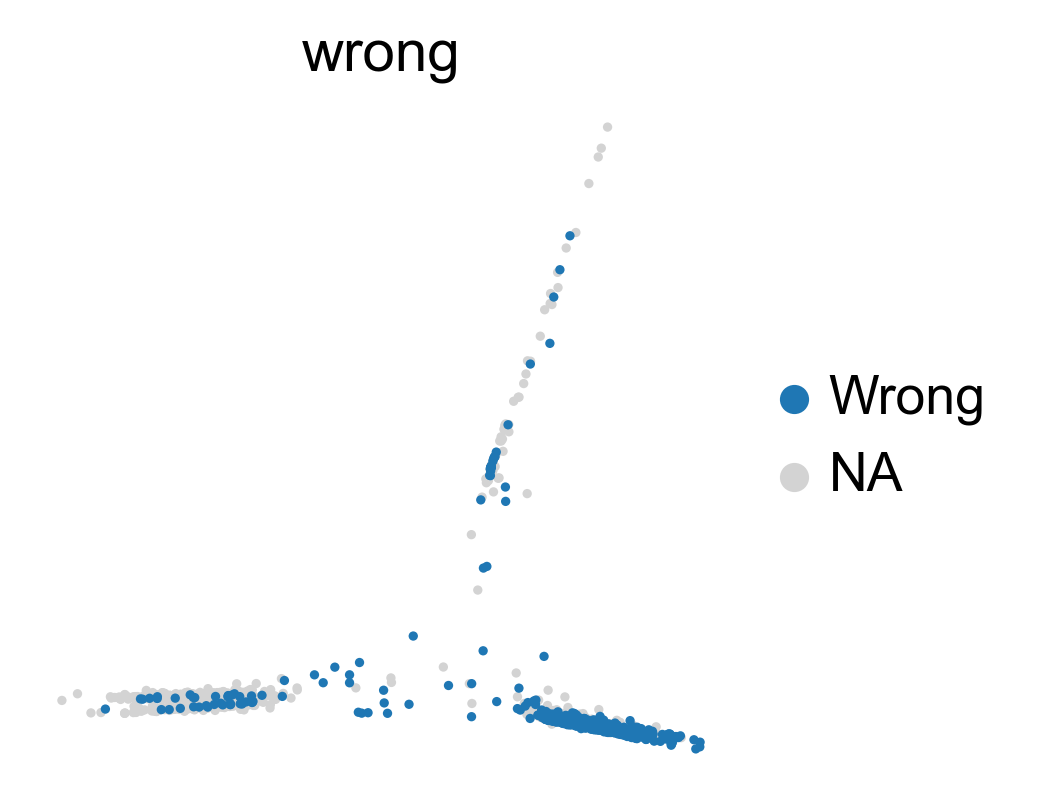

In [22]:
sc.pl.umap(adata,color="wrong",size=20)

In [23]:
name = intested

Calculate the numer of wrong predictions in each cell type

In [24]:
df = adata.obs[[CELL_TYPE_KEY[name],"wrong"]]\
.groupby([CELL_TYPE_KEY[name]])\
.aggregate(['count','size'])\
.reset_index()
df['data'] = name
df

Sample name wrong            data
                                        count size           
0                      101 CELL CONTROL     4    4  GSE110894
1                                 EMPTY     8   12  GSE110894
2                                EMPTY      3    3  GSE110894
3              MA9 IBET RESISTANT CELLS    32  345  GSE110894
4  MA9 IBET RESISTANT CELLS- WITHDRAWAL    11  340  GSE110894
5                    MA9 PARENTALS DMSO   295  372  GSE110894
6            MA9 PARENTALS IBET 400NMOL   159  343  GSE110894

# Overview comparing the prediction and the ground Truth

In [25]:
adata.obs["pred_binary"] = adata.obs["sens_label"]
adata.obs.sens_label = adata.obs.sens_label.cat.rename_categories({1:"Sensitive", 0:"Resistant"})

In [26]:
adata.obs=adata.obs.rename(columns={"sensitivity": "Ground Truth", "sens_label": "Prediction"})

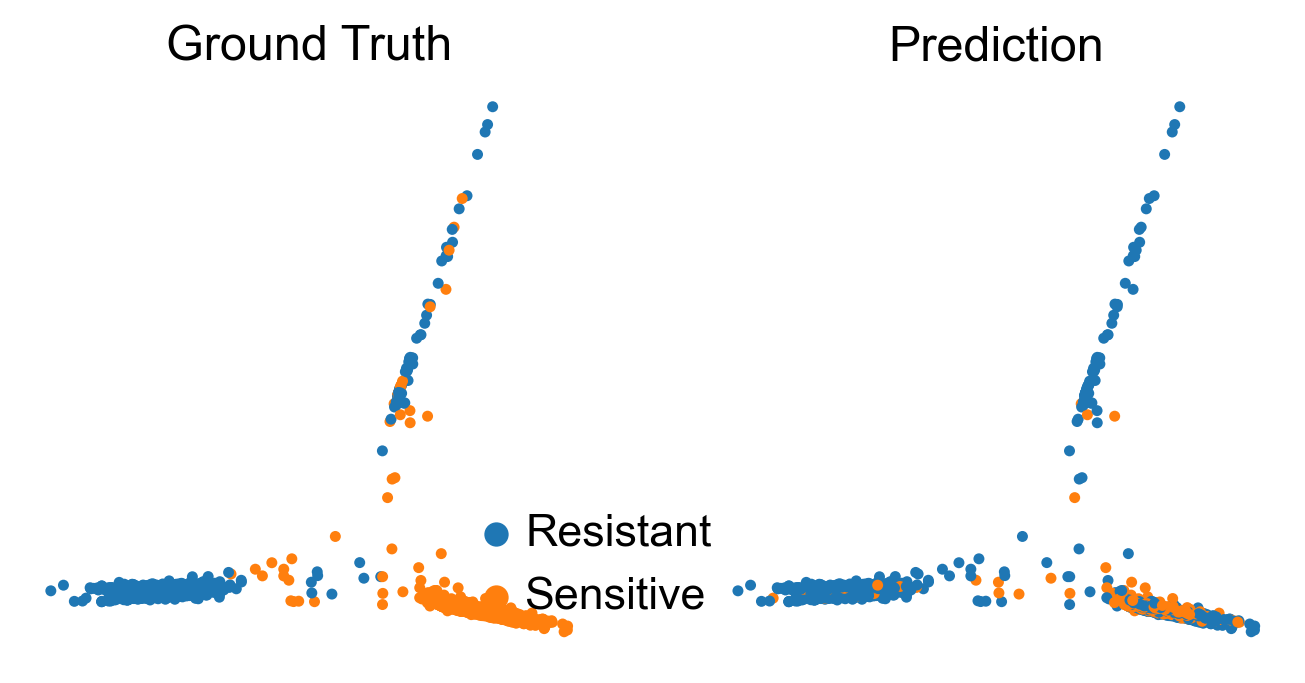

In [27]:
sc.settings.set_figure_params(dpi=250, frameon=False, figsize=(3, 3), facecolor='white')  # low dpi (dots per inch) yields small inline figures
ax = sc.pl.umap(adata,color=['Ground Truth',"Prediction"],size=40,show=False,wspace=0.1)
ax[0].legend().remove()
ax[1].legend(loc ='lower center',bbox_to_anchor=(-0.2, 0),frameon=False) 
plt.savefig("save/figures/figure2A_1"+name + ".tiff")

In [28]:
sens_preds_quantiles = []
for row in adata.obs.itertuples():
    sens_preds_quantiles.append(np.quantile([row.sens_preds,row.rest_preds],(0.025, 0.975)))
quantile_array = np.array(sens_preds_quantiles)
print('Lowest: ',np.min(quantile_array, axis=0))
print('Highest: ',np.max(quantile_array, axis=0))

Lowest:  [0.02500358 0.50728058]
Highest:  [0.49994863 0.97499707]


In [29]:
quantile_array.shape

(1419, 2)

In [30]:
intested

'GSE110894'

In [31]:
latent_mu = pd.read_excel('save/bulk_f'+intested+'latent_mu.xlsx')

In [32]:
latent_mu

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0.331825,0.393439,0.076086,-0.149951,-0.026649,-0.067538,0.212355,-0.063828,-0.411394,0.230509,...,0.113099,-0.276269,-0.023979,0.484988,-0.075043,-0.380036,0.344748,0.391550,-0.013320,0.003215
1,0.362087,0.013333,0.260175,-0.134622,-0.104083,-0.081199,0.125324,-0.171895,0.193624,0.268821,...,-0.152185,0.132697,-0.009843,-0.173032,-0.203833,0.019887,0.221102,0.227935,-0.045366,0.032857
2,0.213790,0.464562,0.077788,0.011035,0.124707,0.035862,0.547421,0.239818,-0.872471,0.315327,...,0.518312,-0.576094,0.118462,1.704323,0.110679,-0.591810,0.636255,0.835206,0.164336,-0.180004
3,0.385190,0.304540,0.154947,-0.160652,-0.083365,-0.073733,0.177941,-0.123700,-0.196753,0.226748,...,-0.016943,-0.109116,-0.030348,0.166640,-0.152776,-0.282222,0.264660,0.296066,-0.069484,0.040805
4,0.366633,0.431453,0.192499,-0.049864,-0.136005,-0.045746,0.328411,0.038435,-0.580761,0.269372,...,0.003087,-0.129544,-0.009396,0.634899,-0.002662,-0.490902,0.304216,0.460947,-0.049115,0.025272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1414,0.292120,0.179685,0.181720,-0.123178,-0.038317,-0.045194,0.128417,-0.172577,-0.046846,0.197884,...,-0.066760,0.037716,0.001894,0.101781,-0.154152,-0.140910,0.211734,0.231576,-0.030559,0.009533
1415,0.324806,-0.529809,0.455527,-0.069862,-0.146368,-0.057498,0.039941,-0.301458,0.979001,0.377461,...,-0.397339,0.674923,0.021151,-0.439510,-0.349778,0.591295,0.202093,0.166048,-0.008759,0.006986
1416,0.317425,-2.830711,0.883483,0.125962,-0.507610,-0.066146,-0.401664,-0.747894,4.262884,1.000491,...,-1.212034,2.301883,-0.048969,-1.593429,-1.025810,2.940469,0.546679,0.149644,0.102871,-0.028147
1417,0.246716,-2.165062,0.541416,0.223964,-0.444377,-0.015467,-0.372689,-0.631899,3.261988,0.717892,...,-0.969471,1.831511,-0.062440,-1.293038,-0.716410,2.253213,0.340360,0.105266,0.068114,0.038819


In [33]:
#For "GSE117872_HN137" and "GSE117872_HN120" the latent_df needs to be indexed in rows to match the quantile_array dimension
import umap
import umap.plot
%matplotlib inline
mapper = umap.UMAP(
    n_neighbors=15,
    min_dist=0.5,
    n_components=2,
    random_state=42).fit(latent_mu)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


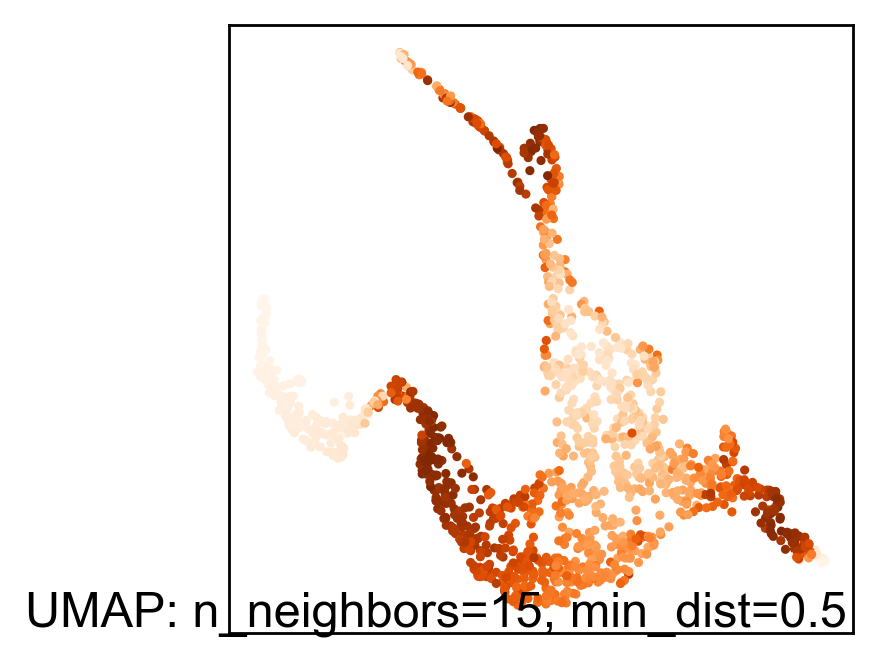

In [34]:
um_pl = umap.plot.points(mapper,labels=quantile_array[:,0],color_key_cmap='Oranges')
um_pl.legend().remove()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


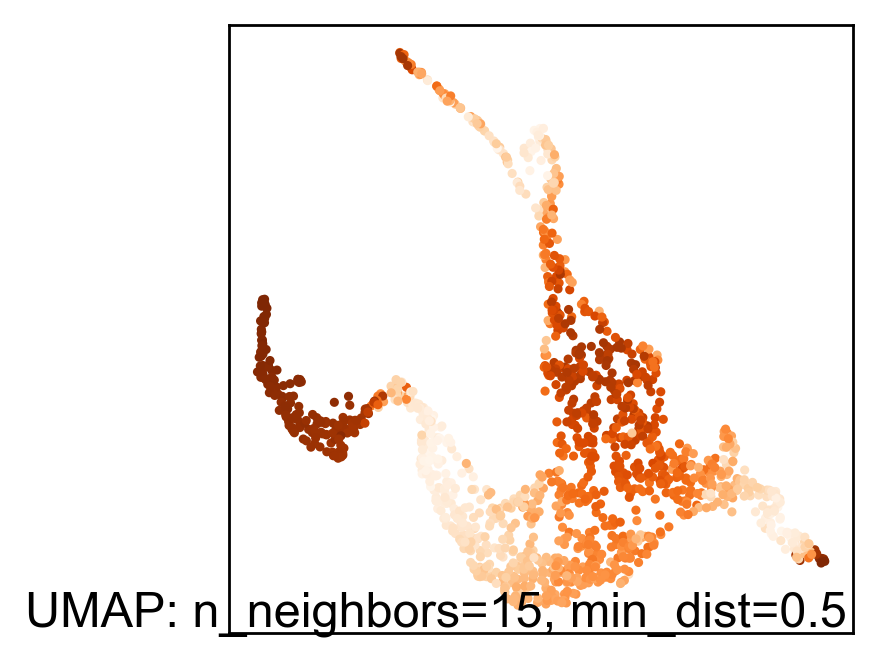

In [35]:
um_pl = umap.plot.points(mapper,labels=quantile_array[:,1],color_key_cmap='Oranges')
um_pl.legend().remove()

<AxesSubplot:title={'center':'Colored by neighborhood Jaccard index'}>

<Figure size 600x400 with 0 Axes>

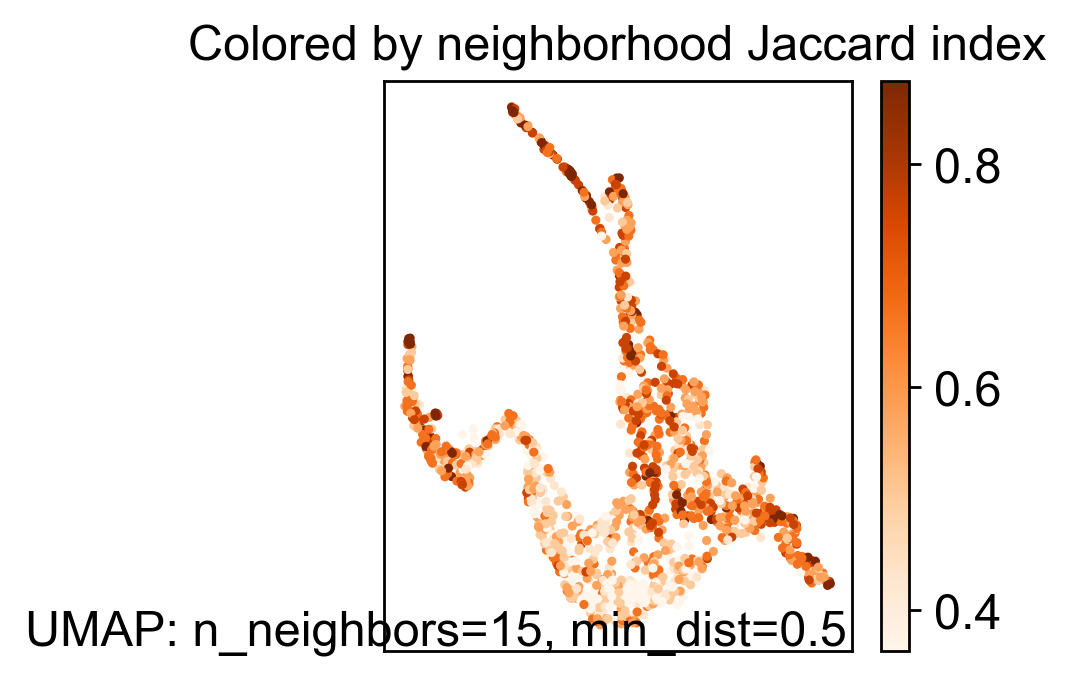

In [36]:
plt.figure(figsize=(6, 4), dpi= 100)
umap.plot.diagnostic(mapper, diagnostic_type='neighborhood',cmap='Oranges')

<AxesSubplot:title={'center':'Colored by RGB coords of Vector Quantization'}>

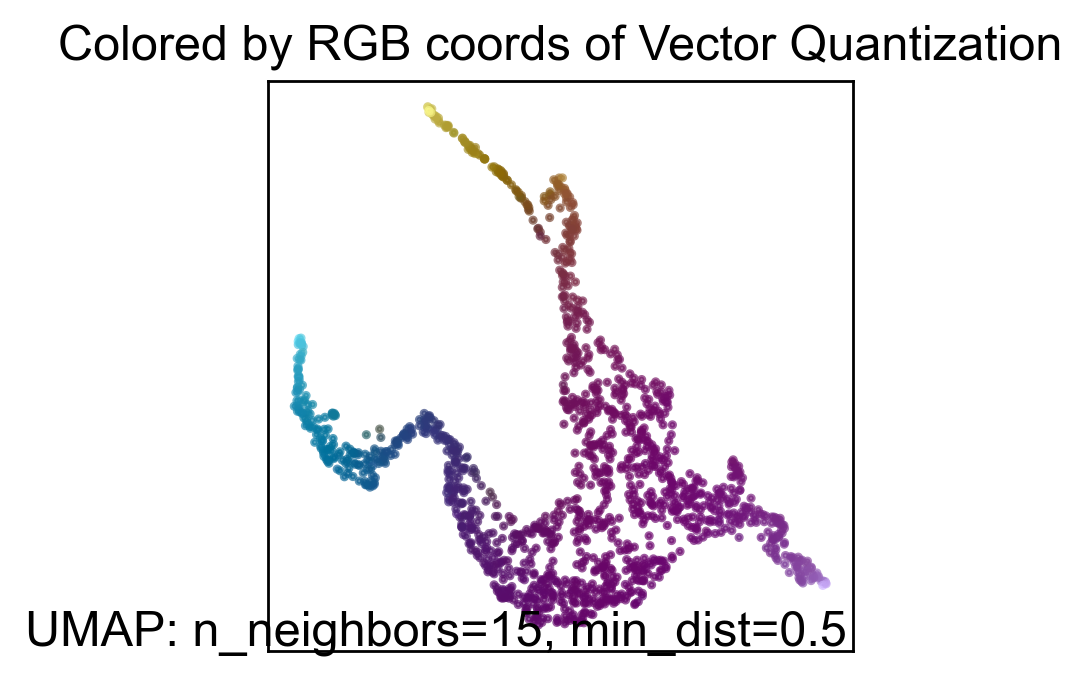

In [37]:
umap.plot.diagnostic(mapper, diagnostic_type='vq')

<AxesSubplot:>

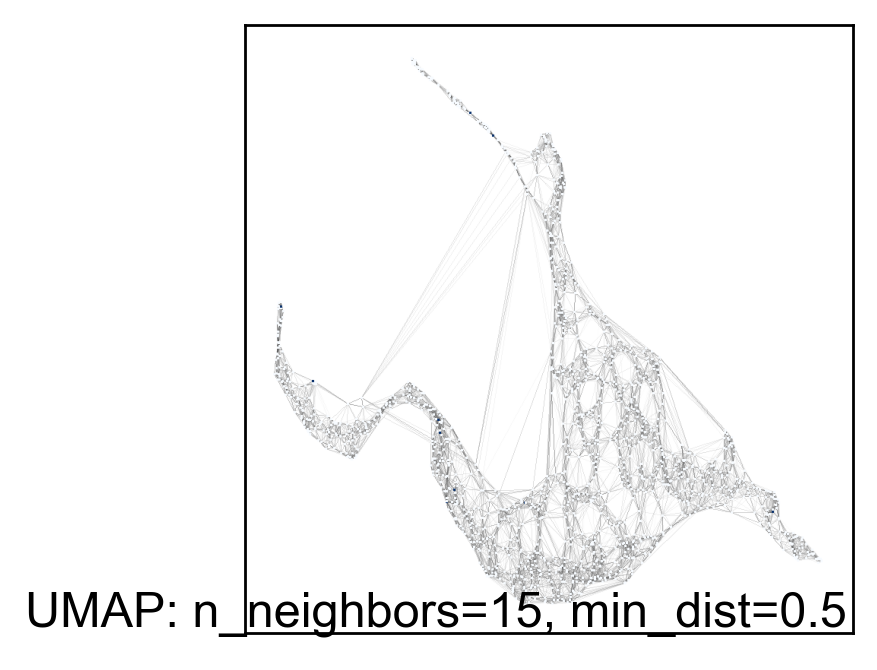

In [38]:
umap.plot.connectivity(mapper, show_points=True)

In [39]:
f1_df = pd.read_excel('save/bulk_f'+intested+'f1_scores.xlsx')
f1_df

,F1 Score,Lower Bound,Upper Bound
0,0.619349,0.603026,0.620561
1,0.604095,0.603026,0.620561
2,0.614435,0.603026,0.620561
3,0.613190,0.603026,0.620561
4,0.610081,0.603026,0.620561
...,...,...,...
995,0.612865,0.603026,0.620561
996,0.612630,0.603026,0.620561
997,0.611988,0.603026,0.620561
998,0.618114,0.603026,0.620561


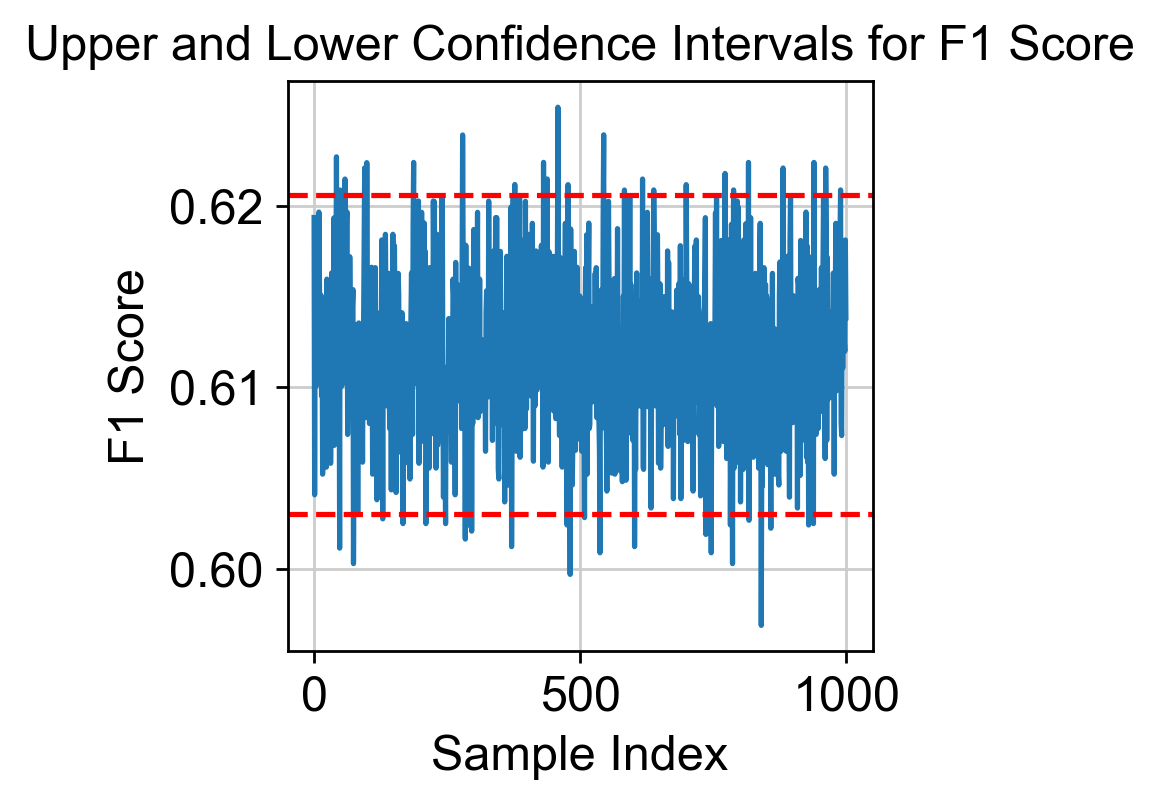

In [40]:
plt.plot(f1_df['F1 Score'])
plt.axhline(np.max(f1_df['Lower Bound']),linestyle = 'dashed', color = 'red')
plt.axhline(np.max(f1_df['Upper Bound']),linestyle = 'dashed', color = 'red')
plt.title('Upper and Lower Confidence Intervals for F1 Score')

# Optionally, you can add labels to the axes as well
plt.xlabel('Sample Index')
plt.ylabel('F1 Score')

# Show the plot
plt.show()

In [41]:
try:
    adata.obs["Sample name"] = adata.obs["cell_color"]
except:
    adata.obs["Sample name"] = adata.obs["Ground Truth"]

# Show the prediction probablity of drug resistant

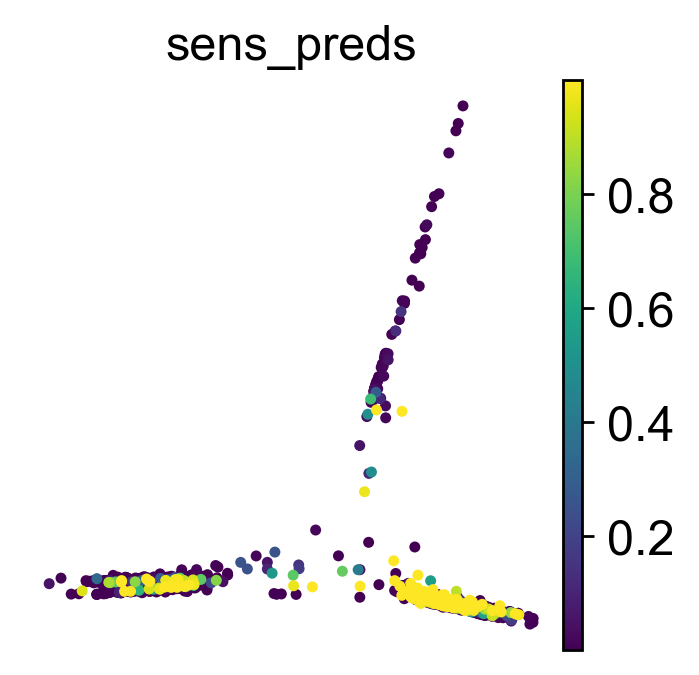

In [42]:
ax = sc.pl.umap(adata,color=["sens_preds"],size=40,palette="Paired",show=False)
plt.savefig("save/figures/figure2A_2"+name + ".tiff")

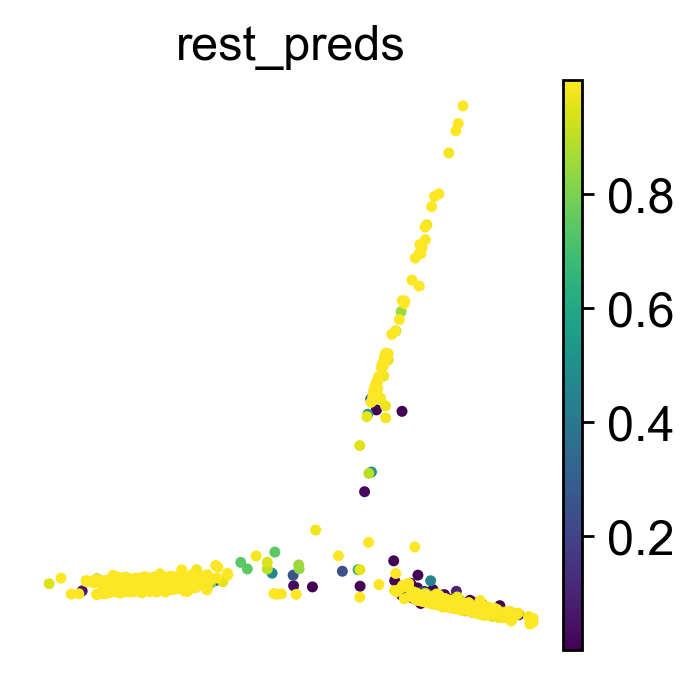

In [43]:
ax = sc.pl.umap(adata,color=["rest_preds"],size=40,palette="Paired",show=False)
plt.savefig("save/figures/figure2A_2"+name + ".tiff")

In [44]:
adata.obs['sensitive']

RPI1_A3     0
RPI1_A4     0
RPI1_A5     0
RPI1_A6     0
RPI1_A7     0
           ..
RPI7_P18    0
RPI7_P19    0
RPI7_P20    0
RPI7_P21    1
RPI7_P22    0
Name: sensitive, Length: 1419, dtype: int64

In [45]:
adata.obs["Sample name"]

RPI1_A3     Resistant
RPI1_A4     Resistant
RPI1_A5     Resistant
RPI1_A6     Resistant
RPI1_A7     Resistant
              ...    
RPI7_P18    Resistant
RPI7_P19    Resistant
RPI7_P20    Resistant
RPI7_P21    Sensitive
RPI7_P22    Resistant
Name: Sample name, Length: 1419, dtype: category
Categories (2, object): ['Resistant', 'Sensitive']

In [46]:
adata

AnnData object with n_obs × n_vars = 1419 × 6644
    obs: 'Plate#', 'Well position', 'Sample name', 'Index-Sort condition', 'Well index', 'sensitive', 'Ground Truth', 'Sensitive_score', 'Resistant_score', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt-', 'pct_counts_mt-', 'total_counts_rps', 'pct_counts_rps', 'total_counts_rpl', 'pct_counts_rpl', 'leiden', 'leiden_origin', 'sens_preds_pret', 'sens_label_pret', 'sens_preds', 'Prediction', 'rest_preds', '0_score', '1_score', 'wrong', 'pred_binary'
    var: 'n_cells', 'mt-', 'rps', 'rpl', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap', 'wrong_colors', 'Ground Truth_colors', 'Prediction_colors'
    obsm: 'X_pca', 'X_pre', 'X_umap', 'X_umap_origin'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

# Show the cell type of the selected dataset

In [47]:
# ax = sc.pl.umap(adata,color=["Sample name"],size=40,palette="Paired",show=False)
# # ax.legend(loc ='lower center',bbox_to_anchor=(0.5, -0.55),frameon=False) 
# plt.savefig("saved/figures/figure2A_3"+name + ".tiff")

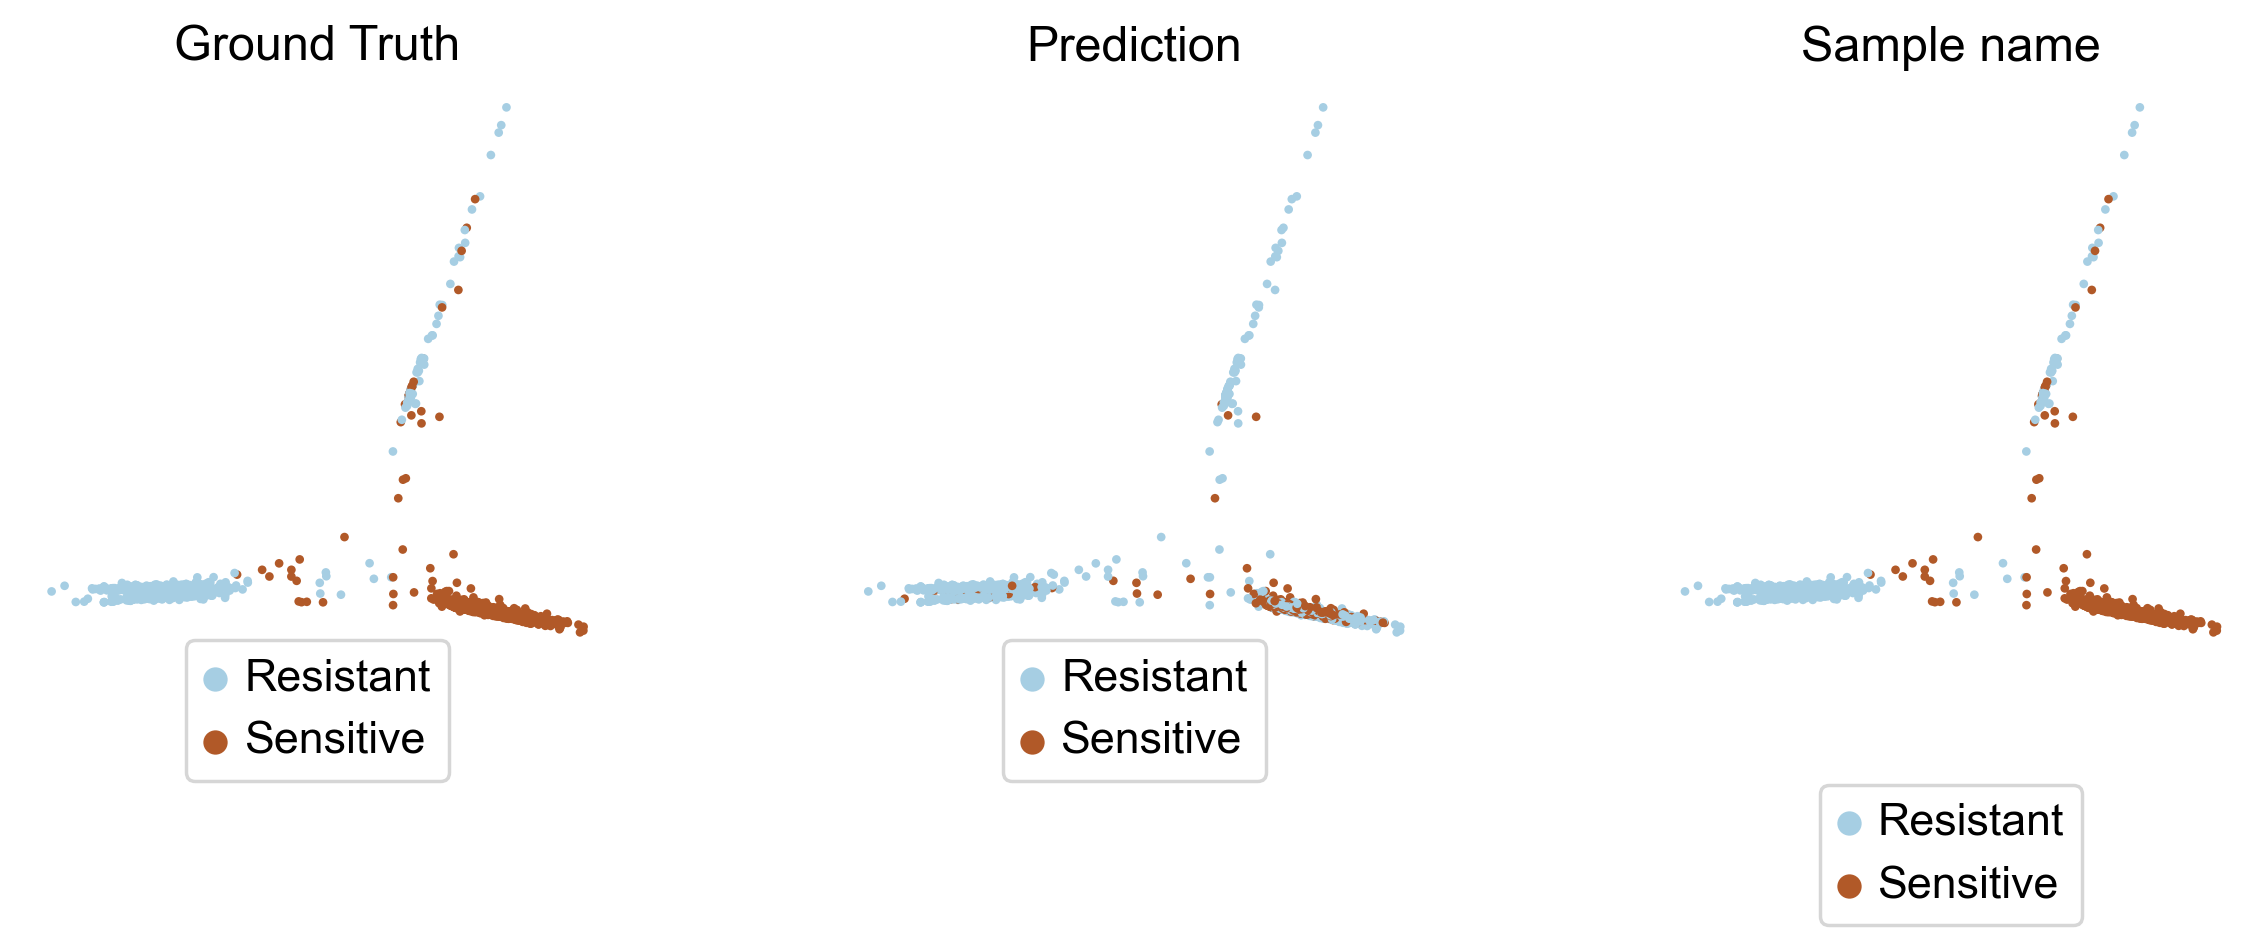

In [48]:
ax = sc.pl.umap(adata,color=['Ground Truth',"Prediction","Sample name"],size=25,palette="Paired",show=False)
ax[0].legend(loc ='lower center',bbox_to_anchor=(0.5, -0.25)) 
ax[1].legend(loc ='lower center',bbox_to_anchor=(0.5, -0.25)) 
ax[2].legend(loc ='lower center',bbox_to_anchor=(0.5, -0.5)) 
#plt.savefig("figure2A_compare"+name + ".tiff")
plt.show()
plt.close()

# Show the gene module score of the sensitive and resistant cell clusters

The sensitive/resistant gene module score is the averaged expression score of the differently express genes within the sensitive/resistant cell cluster

In [49]:
adata = ut.de_score(adata,clustername='pred_binary')

In [50]:
sens_score,s_pval = pearsonr(adata.obs["1_score"],adata.obs["Sensitive_score"])
resistant_score,r_pval = pearsonr(adata.obs["0_score"],adata.obs["Resistant_score"])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


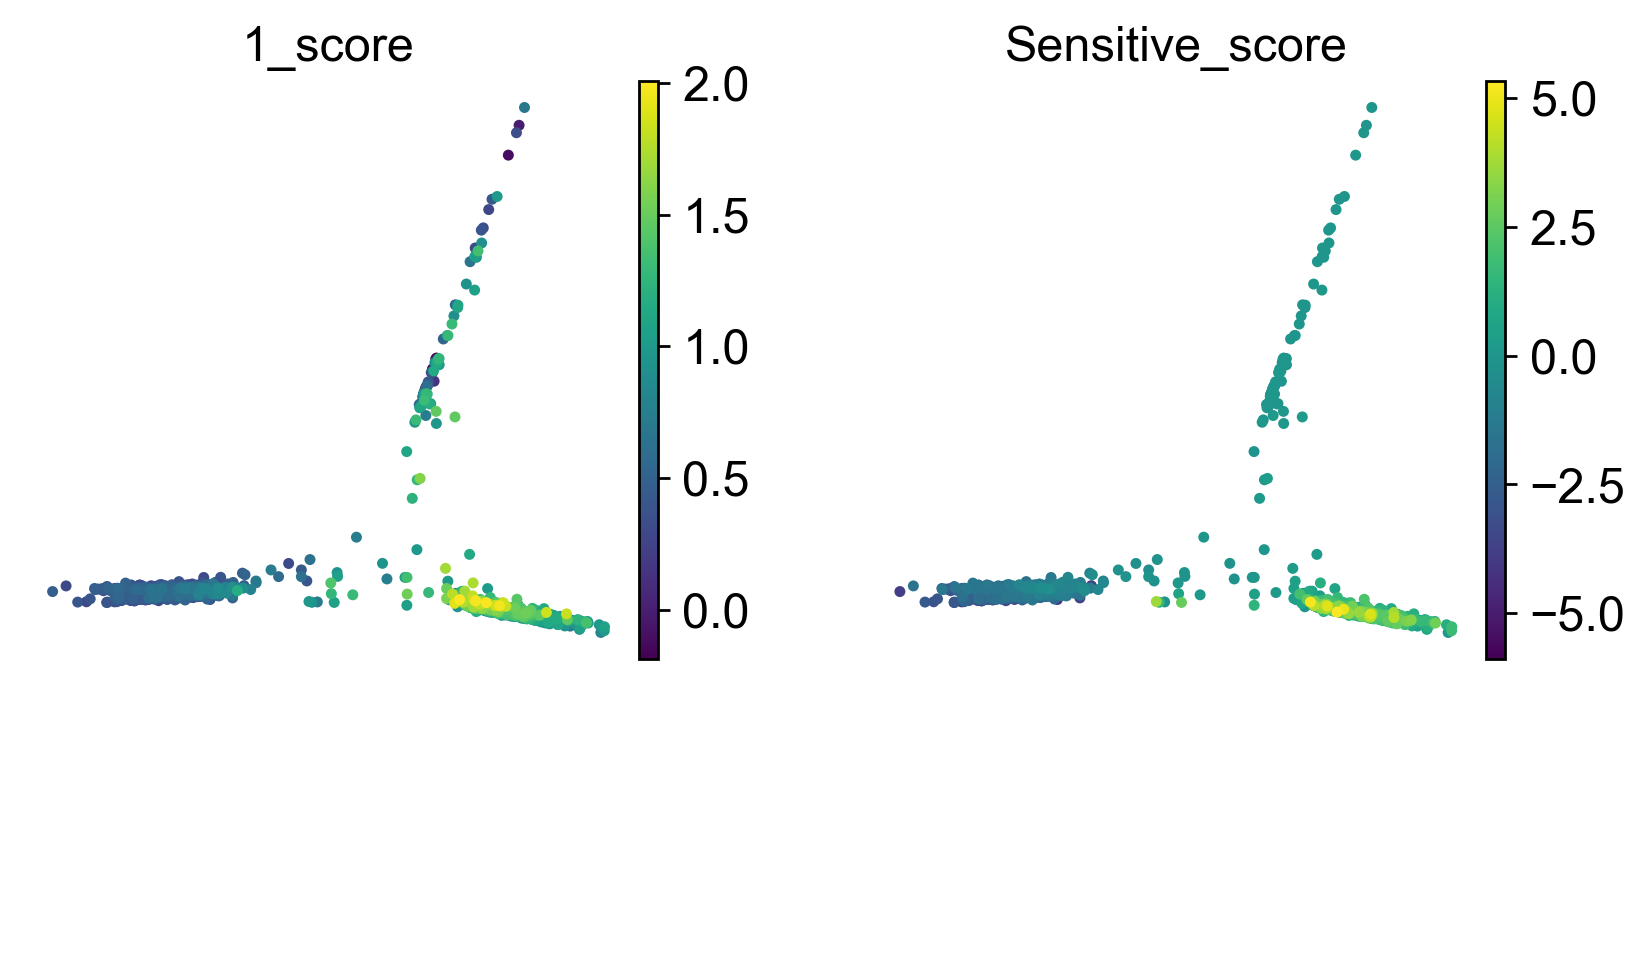

<Figure size 750x750 with 0 Axes>

In [51]:
ax = sc.pl.umap(adata,color=["1_score","Sensitive_score"],size=40,palette="Set2",show=False)
ax[0].legend(loc ='lower center',bbox_to_anchor=(0.5, -0.55),frameon=False) 
ax[1].legend(loc ='lower center',bbox_to_anchor=(0.5, -0.55),frameon=False) 
#plt.savefig("saved/figures/figure2A_4"+name + ".tiff")
plt.show()
plt.clf()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


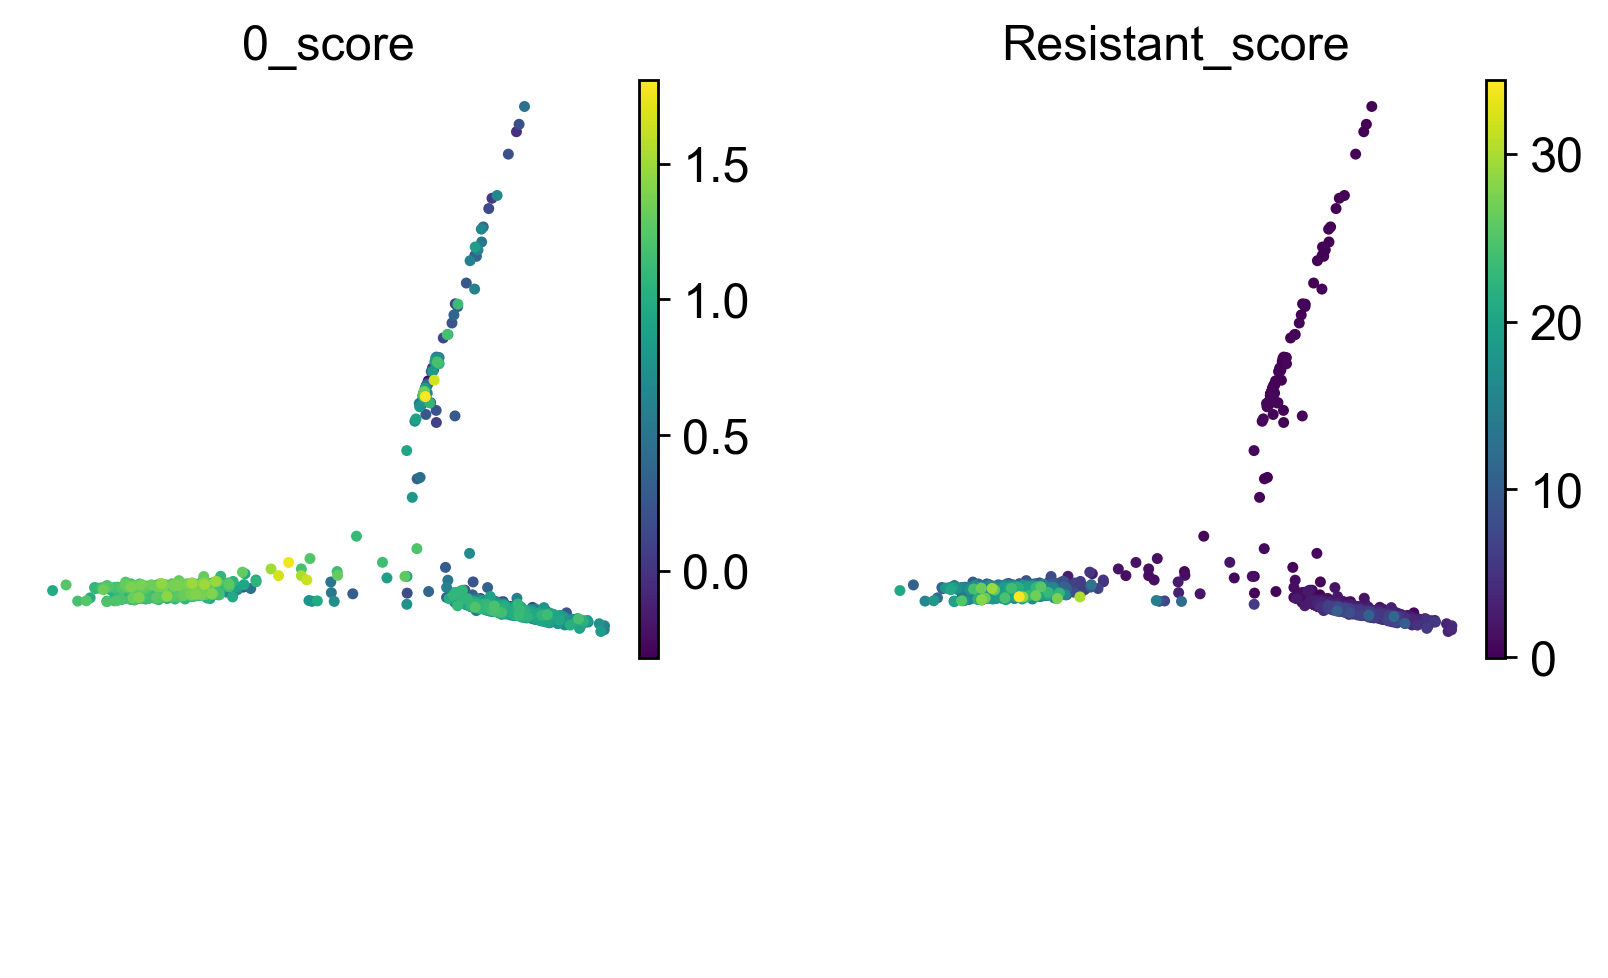

<Figure size 750x750 with 0 Axes>

In [52]:
ax = sc.pl.umap(adata,color=["0_score","Resistant_score"],size=40,palette="flare",show=False)
ax[0].legend(loc ='lower center',bbox_to_anchor=(0.5, -0.55),frameon=False) 
ax[1].legend(loc ='lower center',bbox_to_anchor=(0.5, -0.55),frameon=False) 
#plt.savefig("saved/figures/figure2A_5"+name + ".tiff")
plt.show()
plt.clf()

# pval of the gene module score

In [53]:
def ran_test_score(adata,n_iters=1000):
    ran_results1 = []
    ran_results2 = []

    s_score,s_pval = pearsonr(adata.obs["1_score"],adata.obs["Sensitive_score"])
    r_score,r_pval = pearsonr(adata.obs["0_score"],adata.obs["Resistant_score"])


    for i in range(0,n_iters):

        gl1 = random.sample(list(adata.var.index),50)
        adata=sc.tl.score_genes(adata, gene_list=gl1,score_name="l1_score",copy=True)

        rand_score1,rand_pval1 = pearsonr(adata.obs["l1_score"],adata.obs["Sensitive_score"])
        rand_score2,rand_pval2 = pearsonr(adata.obs["l1_score"],adata.obs["Resistant_score"])

        ran_results1.append(rand_score1)
        ran_results2.append(rand_score2)
        
        
    return adata,ran_results1, s_score,s_pval ,ran_results2,r_score,r_pval

In [54]:
adata,s_ran, s_score,s_pval ,r_ran,r_score,r_pval = ran_test_score(adata,100)

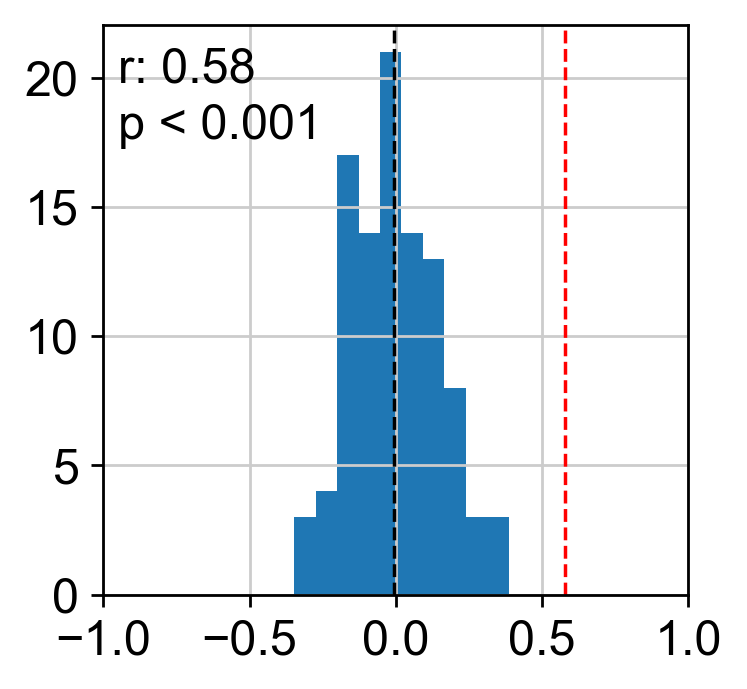

In [55]:
plt.hist(r_ran)
plt.xlim(xmin=-1, xmax = 1)
plt.axvline(r_score, color='r', linestyle='dashed', linewidth=1)
plt.axvline(np.mean(r_ran), color='k', linestyle='dashed', linewidth=1)

min_ylim, max_ylim = plt.ylim()
#plt.text(-1, max_ylim*0.7, 'Mean: {:.2f}'.format(np.mean(r_ran)))
plt.text(-0.95, max_ylim*0.8, 'p < 0.001', color='k')
plt.text(-0.95, max_ylim*0.9, 'r: {:.2f}'.format(r_score), color='k')
plt.show()

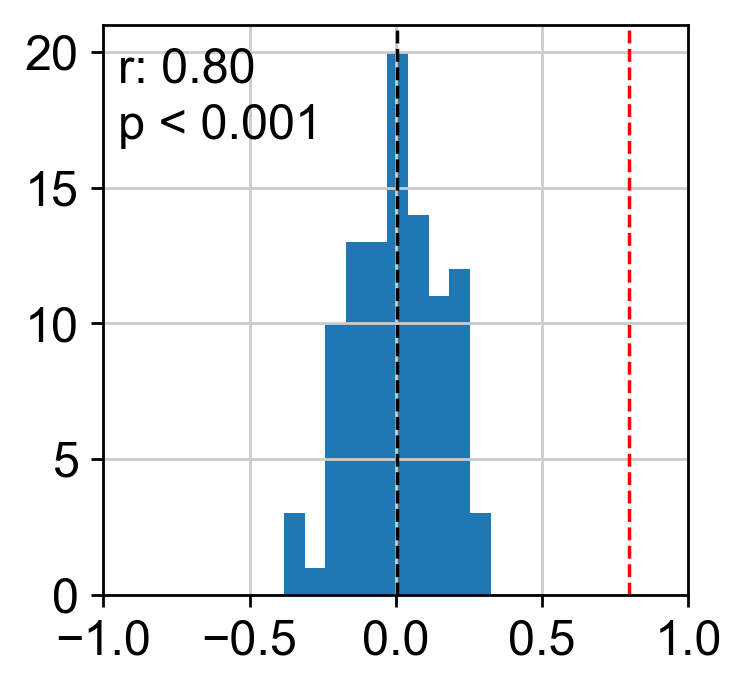

In [56]:
plt.hist(s_ran)
plt.xlim(xmin=-1, xmax = 1)
plt.axvline(s_score, color='r', linestyle='dashed', linewidth=1)
plt.axvline(np.mean(s_ran), color='k', linestyle='dashed', linewidth=1)

min_ylim, max_ylim = plt.ylim()
#plt.text(-1, max_ylim*0.7, 'Mean: {:.2f}'.format(np.mean(r_ran)))
plt.text(-0.95, max_ylim*0.8, 'p < 0.001', color='k')
plt.text(-0.95, max_ylim*0.9, 'r: {:.2f}'.format(s_score), color='k')
plt.savefig("save/figures/random_senstive_gene"+name + '.svg')
plt.show()

# Show the correlation between the gene score and the prediction cell type

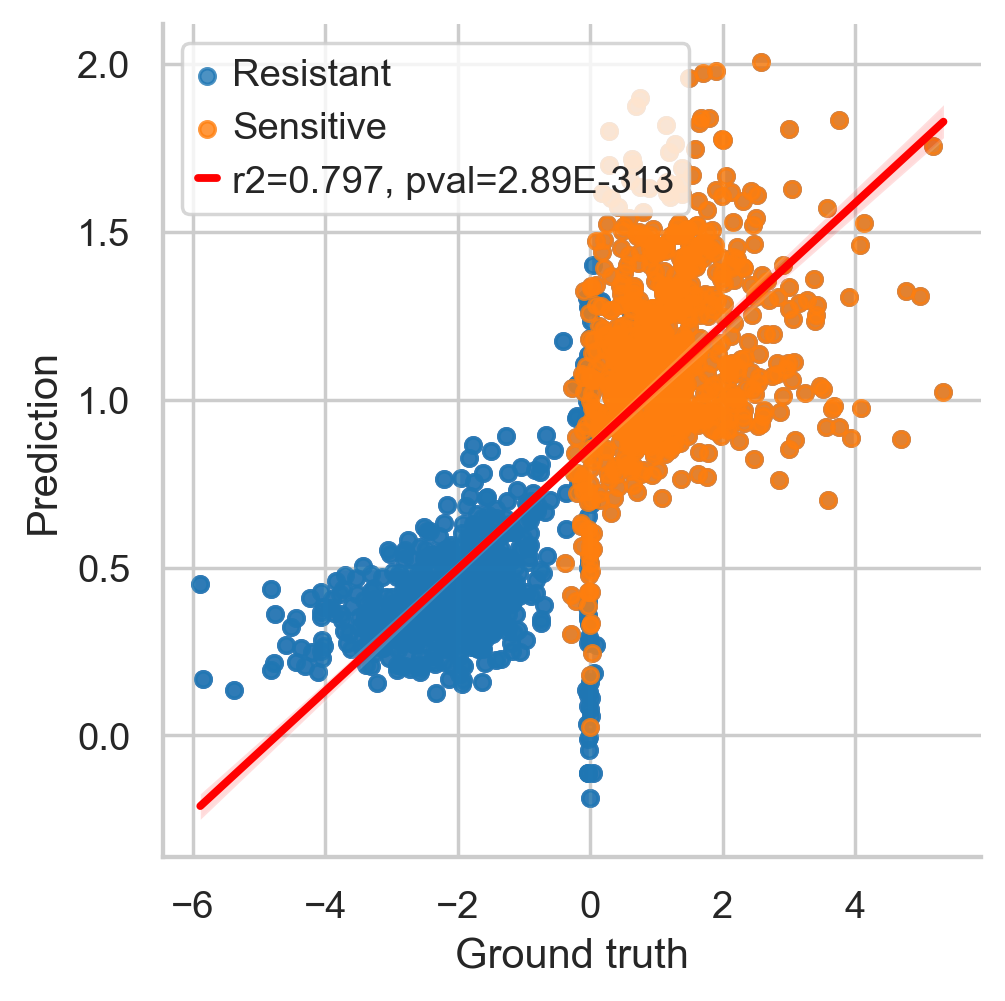

<Figure size 750x750 with 0 Axes>

In [57]:
import scipy as sp
from sklearn.preprocessing import MinMaxScaler

sns.set_theme(style="whitegrid")

score_1 = adata.obs.loc[:,'Sensitive_score'].ravel()
score_2 = adata.obs.loc[:,'1_score'].ravel()
c = adata.obs.loc[:,"Ground Truth"].values


scaler = MinMaxScaler()

DF_0 = pd.DataFrame({"Ground truth":score_1,"Prediction":score_2,"color":c})


r, p = sp.stats.pearsonr(score_1, score_2)

line_kws={'label':"r2={0:.3f}, pval={1:.2E}".format(r,p),"color":"red"}

sns.lmplot(x='Ground truth', y='Prediction', hue='color', data=DF_0, fit_reg=False, legend=False,scatter_kws={"s":20},\
           #palette=sns.color_palette("tab10_r",10)[8:10]
           palette=sns.color_palette("tab10",2)
)

ax = sns.regplot(x=score_1, y=score_2,logx=False, line_kws=line_kws, scatter_kws={"zorder":-1,"s":20})
ax.legend(loc='upper left')
ax.figure.set_size_inches(4, 4)

sns.despine(left=False)
plt.show()
#plt.savefig("saved/figures/Regplot_sesistive_"+name+".tiff")
plt.clf()


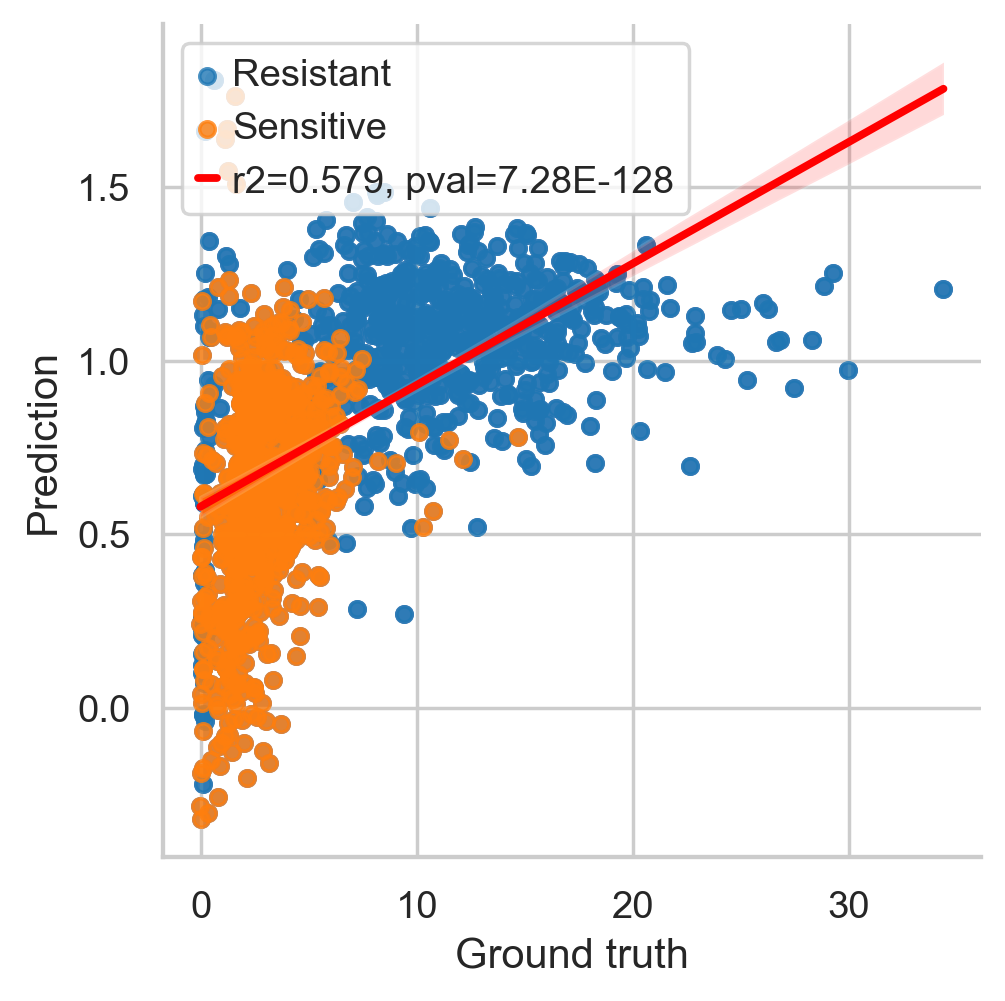

<Figure size 750x750 with 0 Axes>

In [58]:
score_1 = adata.obs.loc[:,'Resistant_score'].ravel()
score_2 = adata.obs.loc[:,'0_score'].ravel()
c = adata.obs.loc[:,"Ground Truth"].values

# score_1 = np.clip(score_1,np.percentile(score_1, 5),np.percentile(score_1, 95))
# score_2 = np.clip(score_2,np.percentile(score_2, 5),np.percentile(score_2, 95))

DF_0 = pd.DataFrame({"Ground truth":score_1,"Prediction":score_2,"color":c})


r, p = sp.stats.pearsonr(score_1, score_2)

line_kws={'label':"r2={0:.3f}, pval={1:.2E}".format(r,p),"color":"red"}

sns.lmplot(x='Ground truth', y='Prediction', hue='color', data=DF_0, fit_reg=False, legend=False,scatter_kws={"s":20},\
           #palette=sns.color_palette("tab10_r",10)[8:10]
           palette=sns.color_palette("tab10",2)

)

# Use regplot to plot the regression line and use line_kws to set line label for legend
#ax = sns.regplot(x="x", y="y", data=DF_0, scatter_kws={"zorder":-1},

ax = sns.regplot(x=score_1, y=score_2,logx=False, line_kws=line_kws, scatter_kws={"zorder":-1,"s":20})
ax.legend(loc='upper left')
ax.figure.set_size_inches(4, 4)

sns.despine(left=False)
#plt.savefig("saved/figures/Regplot_resistant_"+name+".tiff")
plt.show()
plt.clf()

In [59]:
r_pval

7.283743080092523e-128